In [ ]:
!pip install -q lightgbm==4.3.0
!pip install -q sentence-transformers==3.0.1
!pip install -q seaborn==0.13.2
!pip install -q matplotlib==3.9.2
!pip install -q torch torchvision torchaudio
!pip install -q joblib==1.4.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
import torch
print("✅ CUDA available:", torch.cuda.is_available())


✅ CUDA available: True


In [ ]:
!pip install -q seaborn matplotlib scikit-learn numpy


In [ ]:
!pip install pandas numpy scikit-learn lightgbm torch sentence-transformers seaborn matplotlib joblib


In [ ]:
# ======================================
# PRODUCTION-READY COMPLAINT CLASSIFIER
# ======================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import torch
from sentence_transformers import SentenceTransformer
import re
import joblib
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# 1. DATA PROCESSING
# -----------------------------
def load_and_clean_data(file_path):
    """Load and clean the complaint data"""
    df = pd.read_csv("/content/processed_complaints_bilingual.csv")

    print(f"📊 Initial dataset shape: {df.shape}")
    print("Category distribution:")
    print(df['Category'].value_counts())

    def clean_text(text):
        if pd.isna(text):
            return ""
        text = str(text).strip()
        if len(text) < 15:
            return ""
        text = re.sub(r'[^\w\s\u0900-\u097F!?.,]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    print("🧹 Applying proper cleaning...")
    df['cleaned_text'] = df['Standardized_Complaint'].astype(str).apply(clean_text)
    df = df[df['cleaned_text'].str.len() > 0]

    print(f"📊 Final dataset: {len(df)} samples")
    print("Category distribution:")
    print(df['Category'].value_counts())

    return df

# -----------------------------
# 2. FEATURE ENGINEERING
# -----------------------------
def create_features(df):
    """Create features for the model"""

    keyword_groups = {
        'water_related': ['water', 'पाणी', 'pipe', 'supply', 'टँकर', 'नळ', 'पाणीपुरवठा'],
        'electricity_related': ['electric', 'power', 'वीज', 'light', 'transformer', 'विद्युत', 'outage'],
        'road_related': ['road', 'रस्ता', 'pothole', 'repair', 'खड्डा', 'दुरुस्ती', 'highway'],
        'sanitation_related': ['garbage', 'कचरा', 'waste', 'clean', 'स्वच्छता', 'drain', 'ड्रेनेज'],
        'health_related': ['health', 'आरोग्य', 'hospital', 'ambulance', 'medical', 'doctor', 'दवाखाना'],
        'education_related': ['school', 'शाळा', 'education', 'teacher', 'शिक्षण', 'college', 'विद्यार्थी']
    }

    def create_structural_features(texts):
        feature_data = []
        for text in texts:
            features = []
            for domain, words in keyword_groups.items():
                present = any(word in text.lower() for word in words)
                features.append(1 if present else 0)

            features.append(len(text))
            features.append(len(text.split()))
            features.append(len(text) / max(len(text.split()), 1))

            has_marathi = any(char in text for char in 'अआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह')
            features.append(1 if has_marathi else 0)

            urgent_words = ['urgent', 'immediate', 'emergency', 'तत्काळ', 'तुरंत', 'जरुरी']
            has_urgency = any(word in text.lower() for word in urgent_words)
            features.append(1 if has_urgency else 0)

            has_numbers = bool(re.search(r'\d+', text))
            features.append(1 if has_numbers else 0)

            feature_data.append(features)

        return np.array(feature_data)

    # Create structural features
    X_struct = create_structural_features(df['cleaned_text'].tolist())

    # Generate embeddings
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"🧠 Using device: {device}")

    print("📊 Generating embeddings...")
    embed_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    embeddings = embed_model.encode(
        df['cleaned_text'].tolist(),
        batch_size=64,
        show_progress_bar=True,
        convert_to_tensor=False,
        normalize_embeddings=True
    )

    # Combine features
    X_combined = np.hstack([embeddings, X_struct])
    print(f"🚀 Feature shape: {X_combined.shape}")

    return X_combined, embed_model, keyword_groups

# -----------------------------
# 3. MODEL TRAINING
# -----------------------------
def train_model(X_combined, y, test_size=0.3):
    """Train the classification model"""

    # Split data first to avoid leakage
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_combined, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    print(f"📚 Training set: {len(X_train_full)} samples")
    print(f"🧪 Test set: {len(X_test_full)} samples")

    # Feature selection on training data only
    selector = SelectKBest(f_classif, k=100)
    X_train_selected = selector.fit_transform(X_train_full, y_train)
    X_test_selected = selector.transform(X_test_full)

    print(f"🎯 Selected {X_train_selected.shape[1]} features")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train LightGBM model
    print("\n🚀 Training model...")

    lgb_params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': 5,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'lambda_l1': 1.0,
        'lambda_l2': 1.0,
        'verbosity': -1,
        'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    }

    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

    lgb_model = lgb.train(
        params=lgb_params,
        train_set=train_data,
        num_boost_round=200,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(20, verbose=True)]
    )

    return (lgb_model, selector, scaler,
            X_train_scaled, X_test_scaled,
            y_train, y_test, X_train_selected.shape[1])

# -----------------------------
# 4. EVALUATION
# -----------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, le):
    """Evaluate model performance"""

    train_preds = np.argmax(model.predict(X_train), axis=1)
    test_preds = np.argmax(model.predict(X_test), axis=1)

    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average='weighted')

    print("\n📊 EVALUATION RESULTS:")
    print(f"🎯 Training Accuracy: {train_accuracy:.4f}")
    print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
    print(f"🎯 Test Weighted F1: {test_f1:.4f}")
    print(f"📊 Overfitting gap: {train_accuracy - test_accuracy:.4f}")

    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, test_preds, target_names=le.classes_))

    return train_accuracy, test_accuracy, test_f1

# -----------------------------
# 5. PREDICTION PIPELINE
# -----------------------------
class ComplaintClassifier:
    """Production-ready complaint classifier"""

    def __init__(self, model, selector, scaler, embed_model, le, keyword_groups, expected_feature_dim):
        self.model = model
        self.selector = selector
        self.scaler = scaler
        self.embed_model = embed_model
        self.le = le
        self.keyword_groups = keyword_groups
        self.expected_feature_dim = expected_feature_dim

        # Education boosting patterns
        self.education_patterns = {
            'school_infrastructure': [
                (r'school\s+(building|roof|wall|classroom)', 3),
                (r'शाळ.*(इमारत|छत|भिंत|वर्ग)', 3),
                (r'building.*repair', 2),
                (r'इमारत.*दुरुस्ती', 2)
            ],
            'teachers_staff': [
                (r'teacher.*not.*available', 3),
                (r'शिक्षक.*नाही', 3),
                (r'no.*teacher', 2),
                (r'staff.*absent', 2)
            ],
            'student_amenities': [
                (r'midday\s+meal', 3),
                (r'मध्यान्ह\s+भोजन', 3),
                (r'books.*not', 2),
                (r'पुस्तक.*नाही', 2),
                (r'uniform', 1),
                (r'गणवेश', 1)
            ]
        }

    def clean_text(self, text):
        """Clean input text"""
        if pd.isna(text):
            return ""
        text = str(text).strip()
        if len(text) < 15:
            return ""
        text = re.sub(r'[^\w\s\u0900-\u097F!?.,]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def create_features_for_prediction(self, text):
        """Create features for a single text"""
        cleaned_text = self.clean_text(text)

        # Structural features
        features = []
        for domain, words in self.keyword_groups.items():
            present = any(word in cleaned_text.lower() for word in words)
            features.append(1 if present else 0)

        features.append(len(cleaned_text))
        features.append(len(cleaned_text.split()))
        features.append(len(cleaned_text) / max(len(cleaned_text.split()), 1))

        has_marathi = any(char in cleaned_text for char in 'अआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह')
        features.append(1 if has_marathi else 0)

        urgent_words = ['urgent', 'immediate', 'emergency', 'तत्काळ', 'तुरंत', 'जरुरी']
        has_urgency = any(word in cleaned_text.lower() for word in urgent_words)
        features.append(1 if has_urgency else 0)

        has_numbers = bool(re.search(r'\d+', cleaned_text))
        features.append(1 if has_numbers else 0)

        structural_features = np.array([features])

        # Generate embedding
        text_embedding = self.embed_model.encode([cleaned_text])

        # Combine features
        feature_combined = np.hstack([text_embedding, structural_features])

        return feature_combined, cleaned_text

    def predict(self, text, confidence_threshold=0.6, use_education_boost=True):
        """Predict category for a complaint text"""
        try:
            if len(self.clean_text(text)) < 15:
                return "Unknown", 0.0

            # Create features
            feature_combined, cleaned_text = self.create_features_for_prediction(text)

            # Apply feature selection and scaling
            feature_selected = self.selector.transform(feature_combined)
            feature_scaled = self.scaler.transform(feature_selected)

            # Predict
            probs = self.model.predict(feature_scaled)
            pred_idx = np.argmax(probs)
            confidence = probs[0][pred_idx]
            predicted_class = self.le.classes_[pred_idx]

            # Apply education boosting if enabled
            if use_education_boost:
                predicted_class, confidence = self._apply_education_boost(
                    cleaned_text, predicted_class, confidence, probs[0]
                )

            # Apply confidence threshold
            if confidence < confidence_threshold:
                return "Uncertain", confidence

            return predicted_class, float(confidence)

        except Exception as e:
            print(f"⚠️ Prediction error: {e}")
            return "Unknown", 0.0

    def _apply_education_boost(self, text, current_class, current_confidence, all_probs,
                             education_boost=2.0, min_education_prob=0.2):
        """Apply education class boosting"""
        if current_class == "Education" or current_class in ["Uncertain", "Unknown"]:
            return current_class, current_confidence

        # Check education signals
        education_score = 0
        cleaned_text = text.lower()

        for pattern_type, patterns in self.education_patterns.items():
            for pattern, weight in patterns:
                if re.search(pattern, cleaned_text, re.IGNORECASE):
                    education_score += weight

        # Apply boost if strong education signals
        if education_score >= 2:
            education_idx = list(self.le.classes_).index('Education')
            education_prob = all_probs[education_idx]

            if education_prob >= min_education_prob:
                boosted_confidence = min(education_prob * education_boost, 0.95)
                if boosted_confidence > current_confidence:
                    return "Education", boosted_confidence

        return current_class, current_confidence

    def predict_batch(self, texts, confidence_threshold=0.6, use_education_boost=True):
        """Predict categories for multiple texts"""
        results = []
        for text in texts:
            category, confidence = self.predict(text, confidence_threshold, use_education_boost)
            results.append((category, confidence))
        return results

# -----------------------------
# 6. MAIN EXECUTION
# -----------------------------
def main():
    """Main execution function"""

    # Load and prepare data
    DATA_PATH = "/content/processed_complaints_bilingual.csv"
    df = load_and_clean_data(DATA_PATH)

    # Encode target
    le = LabelEncoder()
    y = le.fit_transform(df['Category'])
    num_classes = len(le.classes_)
    print(f"🎯 Number of classes: {num_classes}")

    # Create features
    X_combined, embed_model, keyword_groups = create_features(df)

    # Train model
    (lgb_model, selector, scaler,
     X_train_scaled, X_test_scaled,
     y_train, y_test, feature_dim) = train_model(X_combined, y)

    # Evaluate model
    train_acc, test_acc, test_f1 = evaluate_model(
        lgb_model, X_train_scaled, X_test_scaled, y_train, y_test, le
    )

    # Create classifier instance
    classifier = ComplaintClassifier(
        model=lgb_model,
        selector=selector,
        scaler=scaler,
        embed_model=embed_model,
        le=le,
        keyword_groups=keyword_groups,
        expected_feature_dim=feature_dim
    )

    # Test predictions
    print("\n🧪 Testing Predictions...")

    test_cases = [
        'No water supply in our village for 3 days, urgent help needed immediately!',
        'गावात वीज पुरवठा खंडित झाला आहे, तातडीने दुरुस्ती हवी',
        'Road full of potholes needs immediate repair before monsoon season',
        'पाणी टँकरची तातडीची मागणी, गावात गंभीर पाणीटंचाई निर्माण झाली आहे',
        'Garbage not collected for 15 days causing serious health hazard',
        'Street lights not working in our area for 3 weeks',
        'School building roof damaged, needs urgent repair',
        'Transformer blast caused electricity outage in entire village'
    ]

    print("\n📝 Prediction Results:")
    for i, text in enumerate(test_cases, 1):
        category, confidence = classifier.predict(text)
        confidence_status = "HIGH" if confidence > 0.7 else "MEDIUM" if confidence > 0.5 else "LOW"
        print(f"{i:2d}. {category:<12} ({confidence:.3f} - {confidence_status}): {text[:50]}...")

    # Save pipeline - CORRECTED: Save everything in one file
    print("\n💾 Saving Pipeline...")

    # Save complete pipeline in one file
    pipeline_data = {
        'model': lgb_model,
        'selector': selector,
        'scaler': scaler,
        'embed_model': embed_model,
        'le': le,
        'keyword_groups': keyword_groups,
        'expected_feature_dim': feature_dim,
        'performance': {
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'num_classes': num_classes,
            'dataset_size': len(df)
        }
    }

    joblib.dump(pipeline_data, "complaint_classifier_pipeline.pkl")
    print("✅ Pipeline saved successfully!")

    # Final summary
    print(f"\n🎉 PRODUCTION CLASSIFIER READY!")
    print(f"📊 Dataset: {len(df)} samples")
    print(f"🎯 Test Accuracy: {test_acc:.1%}")
    print(f"📈 Weighted F1: {test_f1:.1%}")
    print(f"🔧 Features: {feature_dim} dimensions")
    print(f"🚀 Education boosting implemented!")

    return classifier

# -----------------------------
# 7. LOADING FUNCTION - CORRECTED
# -----------------------------
def load_classifier(pipeline_path="complaint_classifier_pipeline.pkl"):
    """Load saved classifier pipeline - CORRECTED VERSION"""
    try:
        # Load everything from one file
        pipeline_data = joblib.load(pipeline_path)

        # Create classifier instance with loaded components
        classifier = ComplaintClassifier(
            model=pipeline_data['model'],
            selector=pipeline_data['selector'],
            scaler=pipeline_data['scaler'],
            embed_model=pipeline_data['embed_model'],
            le=pipeline_data['le'],
            keyword_groups=pipeline_data['keyword_groups'],
            expected_feature_dim=pipeline_data['expected_feature_dim']
        )

        print("✅ Classifier loaded successfully!")
        print(f"📊 Model Performance: {pipeline_data['performance']['test_accuracy']:.1%} accuracy")

        return classifier

    except Exception as e:
        print(f"❌ Error loading classifier: {e}")
        return None

# -----------------------------
# 8. USAGE EXAMPLE
# -----------------------------
def usage_example():
    """Show how to use the classifier"""
    print("\n🔧 USAGE EXAMPLE:")

    # Load the classifier
    classifier = load_classifier()

    if classifier is not None:
        # Single prediction
        complaint = "Water pipe broken in sector 5, need immediate repair"
        category, confidence = classifier.predict(complaint)
        print(f"Single prediction: '{complaint}' -> {category} (confidence: {confidence:.3f})")

        # Batch prediction
        complaints = [
            "No electricity in our area for 2 days",
            "School building needs urgent repair",
            "Garbage not collected for 1 week"
        ]
        results = classifier.predict_batch(complaints)
        print("\nBatch predictions:")
        for i, (complaint, (category, confidence)) in enumerate(zip(complaints, results), 1):
            print(f"{i}. '{complaint[:30]}...' -> {category} ({confidence:.3f})")

# -----------------------------
# RUN THE PIPELINE
# -----------------------------
if __name__ == "__main__":
    # Train and save the model
    classifier = main()

    # Show usage example
    usage_example()

📊 Initial dataset shape: (7307, 9)
Category distribution:
Category
Health         1260
Sanitation     1230
Road           1216
Water          1212
Electricity    1196
Others          688
Education       505
Name: count, dtype: int64
🧹 Applying proper cleaning...
📊 Final dataset: 4196 samples
Category distribution:
Category
Health         833
Water          819
Sanitation     810
Electricity    780
Others         423
Road           390
Education      141
Name: count, dtype: int64
🎯 Number of classes: 7
🧠 Using device: cuda
📊 Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

🚀 Feature shape: (4196, 396)
📚 Training set: 2937 samples
🧪 Test set: 1259 samples
🎯 Selected 100 features

🚀 Training model...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 0.470012

📊 EVALUATION RESULTS:
🎯 Training Accuracy: 0.8533
🎯 Test Accuracy: 0.8261
🎯 Test Weighted F1: 0.8175
📊 Overfitting gap: 0.0272

📋 Classification Report:
              precision    recall  f1-score   support

   Education       0.00      0.00      0.00        42
 Electricity       1.00      0.79      0.88       234
      Health       0.68      0.93      0.79       250
      Others       1.00      1.00      1.00       127
        Road       1.00      0.66      0.79       117
  Sanitation       1.00      0.81      0.89       243
       Water       0.67      0.91      0.77       246

    accuracy                           0.83      1259
   macro avg       0.76      0.73      0.73      1259
weighted avg       0.84    


📊 EVALUATION RESULTS:
🎯 Training Accuracy: 0.8533
🎯 Test Accuracy: 0.8261
🎯 Test Weighted F1: 0.8175
📊 Overfitting gap: 0.0272

📋 Classification Report:
              precision    recall  f1-score   support

   Education       0.00      0.00      0.00        42
 Electricity       1.00      0.79      0.88       234
      Health       0.68      0.93      0.79       250
      Others       1.00      1.00      1.00       127
        Road       1.00      0.66      0.79       117
  Sanitation       1.00      0.81      0.89       243
       Water       0.67      0.91      0.77       246

    accuracy                           0.83      1259
   macro avg       0.76      0.73      0.73      1259
weighted avg       0.84      0.83      0.82      1259



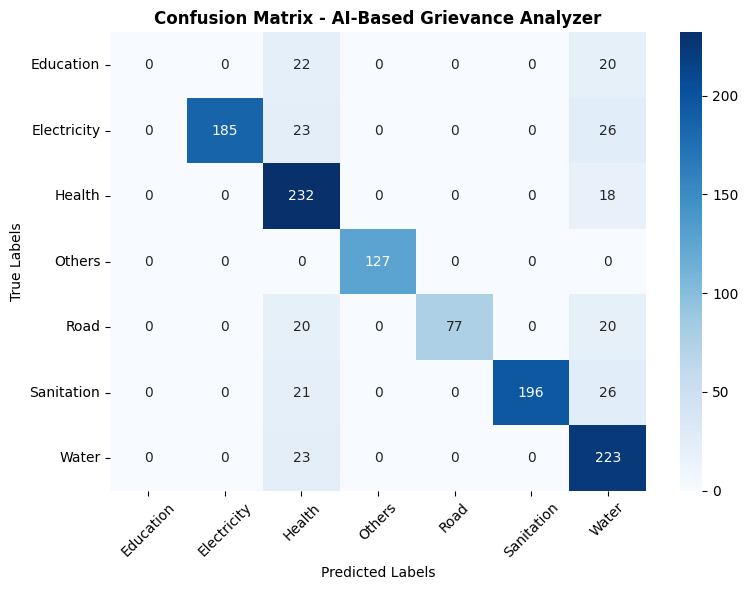

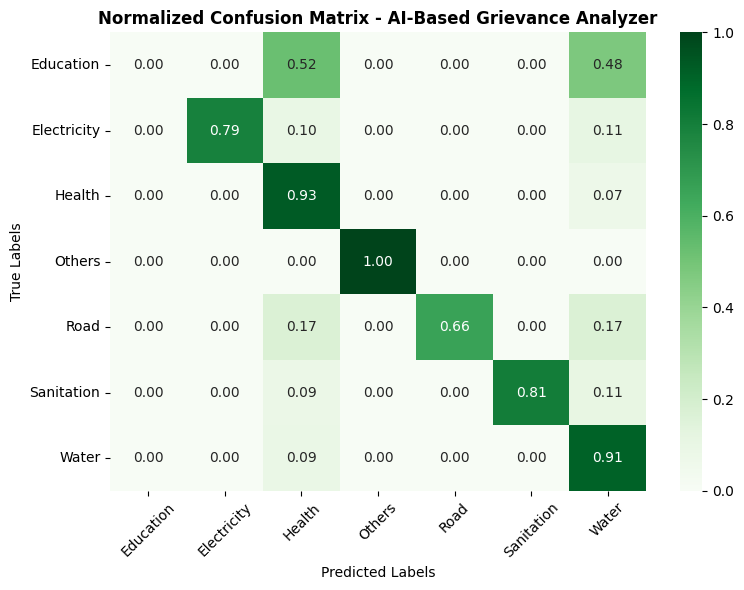

In [ ]:
# ✅ Install necessary libraries (run once in Colab)
!pip install -q seaborn scikit-learn matplotlib numpy joblib

# ✅ Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import joblib

# ================================
# 🔹 MODEL EVALUATION
# ================================

# Load the necessary components from the saved pipeline
try:
    pipeline_data = joblib.load("complaint_classifier_pipeline.pkl")
    model = pipeline_data['model']
    selector = pipeline_data['selector']
    scaler = pipeline_data['scaler']
    le = pipeline_data['le']

    # Re-create training and test sets for evaluation
    # This assumes the original data loading and splitting logic can be replicated
    # If the original data or splits are complex, a different approach might be needed.
    # For this example, we'll reload and split the data.
    # NOTE: In a real production scenario, you would ideally save and load the splits as well.
    DATA_PATH = "/content/processed_complaints_bilingual.csv"
    import pandas as pd
    from sklearn.model_selection import train_test_split
    import re

    def clean_text_eval(text):
        if pd.isna(text):
            return ""
        text = str(text).strip()
        if len(text) < 15:
            return ""
        text = re.sub(r'[^\w\s\u0900-\u097F!?.,]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_eval = pd.read_csv(DATA_PATH)
    df_eval['cleaned_text'] = df_eval['Standardized_Complaint'].astype(str).apply(clean_text_eval)
    df_eval = df_eval[df_eval['cleaned_text'].str.len() > 0]

    y_eval = le.transform(df_eval['Category'])

    # Re-create structural features (assuming keyword_groups are loaded or defined)
    keyword_groups = pipeline_data['keyword_groups'] # Load keyword_groups

    def create_structural_features_eval(texts, keyword_groups):
        feature_data = []
        for text in texts:
            features = []
            for domain, words in keyword_groups.items():
                present = any(word in text.lower() for word in words)
                features.append(1 if present else 0)

            features.append(len(text))
            features.append(len(text.split()))
            features.append(len(text) / max(len(text.split()), 1))

            has_marathi = any(char in text for char in 'अआइईउऊऋएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभभयरलवशषसह')
            features.append(1 if has_marathi else 0)

            urgent_words = ['urgent', 'immediate', 'emergency', 'तत्काळ', 'तुरंत', 'जरुरी']
            has_urgency = any(word in text.lower() for word in urgent_words)
            features.append(1 if has_urgency else 0)

            has_numbers = bool(re.search(r'\d+', text))
            features.append(1 if has_numbers else 0)


            feature_data.append(features)
        return np.array(feature_data)

    X_struct_eval = create_structural_features_eval(df_eval['cleaned_text'].tolist(), keyword_groups)

    # Generate embeddings (assuming embed_model is loaded)
    embed_model = pipeline_data['embed_model']
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embed_model.to(device) # Ensure model is on correct device

    embeddings_eval = embed_model.encode(
        df_eval['cleaned_text'].tolist(),
        batch_size=64,
        show_progress_bar=False, # Suppress progress bar for cleaner output
        convert_to_tensor=False,
        normalize_embeddings=True
    )

    # Combine features
    X_combined_eval = np.hstack([embeddings_eval, X_struct_eval])

    # Apply feature selection and scaling using the loaded selector and scaler
    X_selected_eval = selector.transform(X_combined_eval)
    X_scaled_eval = scaler.transform(X_selected_eval)

    # Split the scaled and selected features
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
        X_scaled_eval, y_eval,
        test_size=0.3, # Use the same test_size as in training
        random_state=42,
        stratify=y_eval
    )


    # 🔸 Predictions
    y_train_pred = np.argmax(model.predict(X_train_scaled), axis=1)
    y_test_pred  = np.argmax(model.predict(X_test_scaled), axis=1)

    # 🔸 Evaluation Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    test_f1   = f1_score(y_test, y_test_pred, average='weighted')

    print("\n📊 EVALUATION RESULTS:")
    print(f"🎯 Training Accuracy: {train_acc:.4f}")
    print(f"🎯 Test Accuracy: {test_acc:.4f}")
    print(f"🎯 Test Weighted F1: {test_f1:.4f}")
    print(f"📊 Overfitting gap: {train_acc - test_acc:.4f}")

    # 🔸 Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # ================================
    # 🔹 CONFUSION MATRIX (Counts)
    # ================================
    cm = confusion_matrix(y_test, y_test_pred)
    class_names = le.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - AI-Based Grievance Analyzer", fontsize=12, weight='bold')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ================================
    # 🔹 NORMALIZED CONFUSION MATRIX
    # ================================
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix - AI-Based Grievance Analyzer", fontsize=12, weight='bold')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("❌ Error: 'complaint_classifier_pipeline.pkl' not found. Please run the training cell first.")
except Exception as e:
    print(f"❌ An error occurred: {e}")